In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')

# import dunestyle.matplotlib as dunestyle
import mplhep
mplhep.style.use(mplhep.style.ROOT)
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

In [2]:
data_path = "/home/henrique/Documents/Atmos_Pandora/data/ereco2/"
anatree_trk = Anatree("../data/anatree_dump_using_sp.root", load_data=False)
anatree_sp = Anatree('', load_data=False)
anatree_mc = Anatree('', load_data=False)
anatree_trk.tree:uproot.TTree
anatree_sp.tree:uproot.TTree
anatree_mc.tree:uproot.TTree

In [3]:
anatree_mc.read_parquet("../data/parquet_anatree_mcparticle_dump2/")
anatree_trk.read_parquet("../data/parquet_anatree_dump_using_reco2/")
anatree_sp.read_parquet("../data/parquet_anatree_dump_using_sp2/")

Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60
Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60
Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60


In [4]:
tmpcontained = uproot.open("../data/trk_sp_dedx_vtx_dump_using_trk.root:t1")
tmpkeys = ['run','subrun','event','isContained']
arr = {}
for c in tmpkeys:
    a = tmpcontained[c].array()
    arr[c] = a
pdcontained = pd.DataFrame(arr)
dfcontained = pl.from_pandas(pdcontained)

In [5]:
def select_numu_cc(df:pl.DataFrame, checkContained = False, isCointained=1):
    df = df.filter(
        (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
    )
    if checkContained:
        df = df.filter(
            (pl.col('LongestTrackContNumu')==isCointained)
        )
    global dfcontained
    df = df.join(dfcontained, on=selection_events())
    df = df.with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        p = pl.col('lep_mom_truth'),
        Ellhd = pl.col("RecoLepEnNumu_mcs_llhd"),
        contained = pl.col("isContained")
        # Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>0).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        # Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>0).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
    ).with_columns(
        pllhd = pl.when(pl.col("Ellhd")>0).then((pl.col('Ellhd')**2 - 0.1057**2).sqrt()).otherwise(0),
    )
    return df

In [6]:

def get_tracks(ana:Anatree):
    dtrack:pl.DataFrame
    dpfp:pl.DataFrame
    dtrack = ana.reco_tracks.collect().sort('trklen_pandoraTrack')#.select(selection_events(['trklen_pandoraTrack']))
    dpfp = ana.pfp.collect()
    dpfp = dpfp.filter(pl.col('pfp_isTrack')==True)
    dtrack = dtrack.join(dpfp, left_on=selection_events('trkPFParticleID_pandoraTrack'), right_on=selection_events('pfp_selfID'))
    dtrack = dtrack.sort('trklen_pandoraTrack', descending=True)
    dtrack = dtrack.group_by(selection_events()).agg(
            pl.all().first()
    )
    dtrack =  dtrack.sort(
        selection_events()
    )
    dtrack = dtrack.select(
        selection_events([
        'trklen_pandoraTrack',
        'trkId_pandoraTrack',
        'trkPFParticleID_pandoraTrack',
        'trkmomrange_pandoraTrack',
        'trkpurity_pandoraTrack',
        'trkcompleteness_pandoraTrack',
        'trkstartx_pandoraTrack',
        'trkstarty_pandoraTrack',
        'trkstartz_pandoraTrack',
        'trkendx_pandoraTrack',
        'trkendy_pandoraTrack',
        'trkendz_pandoraTrack',
        ]
        )
    ).with_columns(
        trklen = pl.col('trklen_pandoraTrack')
    )
    return dtrack

dtrack_mc = get_tracks(anatree_mc)
dtrack_trk = get_tracks(anatree_trk)
dtrack_sp = get_tracks(anatree_sp)
dtrack_all  = pl.concat([dtrack_mc, dtrack_sp])
dtrack_all  = pl.concat([dtrack_all, dtrack_trk])
dtrack_all = dtrack_all.group_by(selection_events()).agg(
    pl.all().first()
)

In [7]:
dfmc = anatree_mc.nu.collect()
dftrk = anatree_trk.nu.collect()
dfsp = anatree_sp.nu.collect()

dfmc = select_numu_cc(dfmc)
dftrk = select_numu_cc(dftrk)
dfsp = select_numu_cc(dfsp)

dfmc = dfmc.join(dtrack_mc, on=selection_events())
dftrk = dftrk.join(dtrack_trk, on=selection_events())
dfsp = dfsp.join(dtrack_sp, on=selection_events())

In [8]:
def check_inverted(df:pl.DataFrame):
    
    def distance_vertex(type='start'):
        return ((pl.col(f"trk{type}x_pandoraTrack")-pl.col('nuvtxx_truth'))**2 +
                (pl.col(f"trk{type}y_pandoraTrack")-pl.col('nuvtxy_truth'))**2 +
                (pl.col(f"trk{type}z_pandoraTrack")-pl.col('nuvtxz_truth'))**2 ).sqrt()
    df = df.with_columns(
         isinverted = pl.when(distance_vertex('start')>=distance_vertex('end')).then(True).otherwise(False),
         distancestart = distance_vertex('start'),
         distanceend = distance_vertex('end'),
    )
    return df
    
dftrk = check_inverted(dftrk)
dfsp = check_inverted(dfsp)
dfmc = check_inverted(dfmc)

In [9]:
from scipy.stats import binned_statistic
def display_2d(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    legendtitle='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    zscale='log',
                    figsize=(14,6.7),
                    loc='upper right'):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale);
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binsx,binsy], cmin = 1, norm=zscale);
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if legendtitle:
        legend = plt.legend(frameon=True, title=legendtitle, loc=loc)
    plt.plot();

def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = '',
                    makefrac = True,
                    fmt='.:',
                    infotype='std',
                    fontsize=25,
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    **kwargs):
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1)
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty*100, manual_std, binsx)
        if ylabel == '':
            ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        if ylabel == '':
            ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    ax.plot(bins_center, val, fmt, markersize=10, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=fontsize, labelpad=labelpad)
    plt.xlabel(xlabel, fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(title=title,fontsize=23, loc=loc)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)

def plot_res(xreco,
            xtrue,
            binsx = np.linspace(-1,2,200),
            xlabel = r'$\frac{E_{reco}}{E_{true}}-1$',
            ylabel = r'# of events',
            fontsize=25,
            xscale='linear',
            yscale='linear',
            loc='best',
            title='',
            **kwargs):

    val = xreco/xtrue - 1;
    plt.hist(val, bins=binsx, histtype='step', **kwargs)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    legend = plt.legend(title=title,fontsize=23, loc=loc)
    plt.xlim(binsx[0],binsx[-1])

<Figure size 1400x600 with 0 Axes>

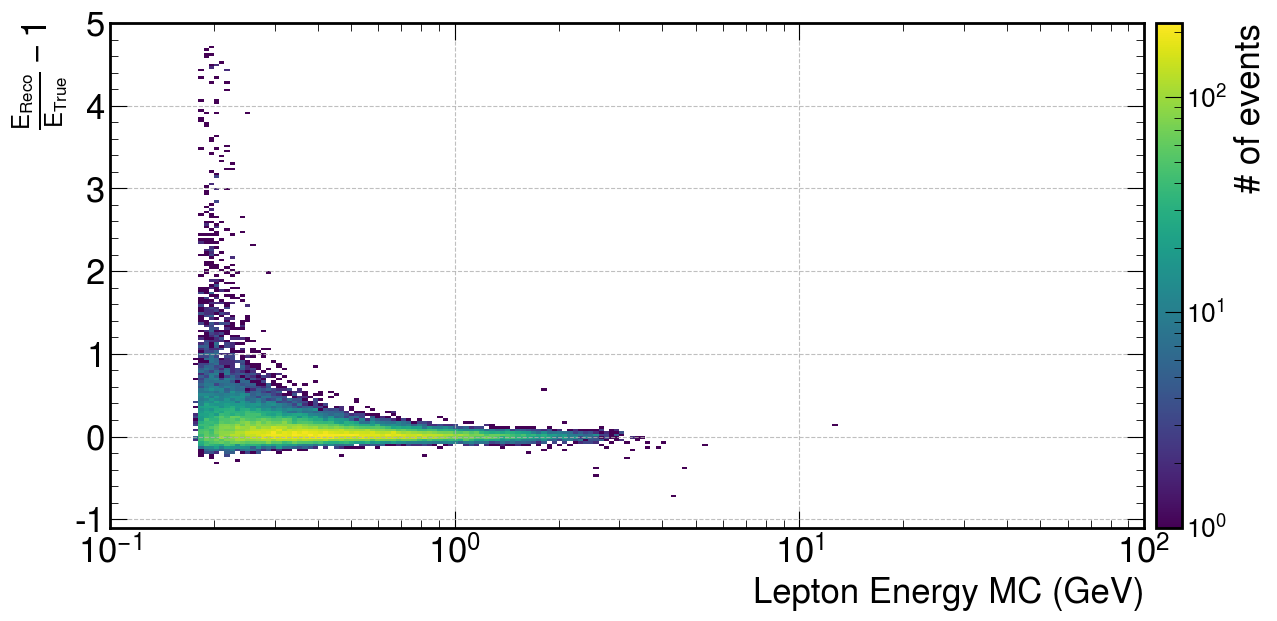

<Figure size 1400x600 with 0 Axes>

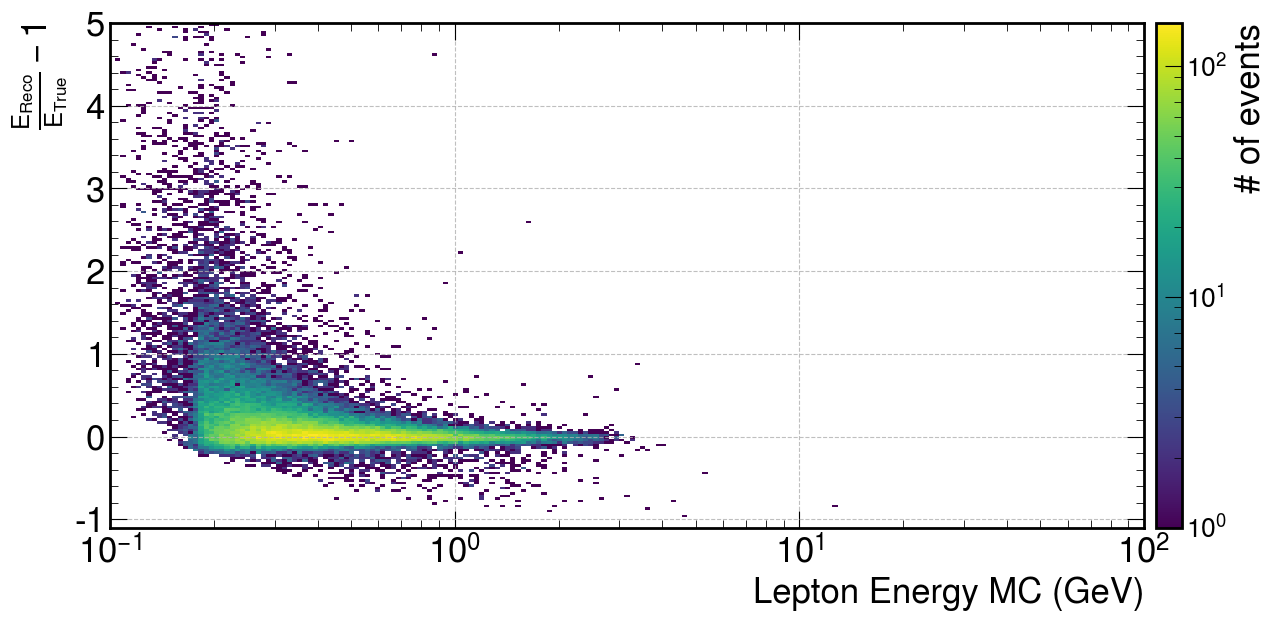

<Figure size 1400x600 with 0 Axes>

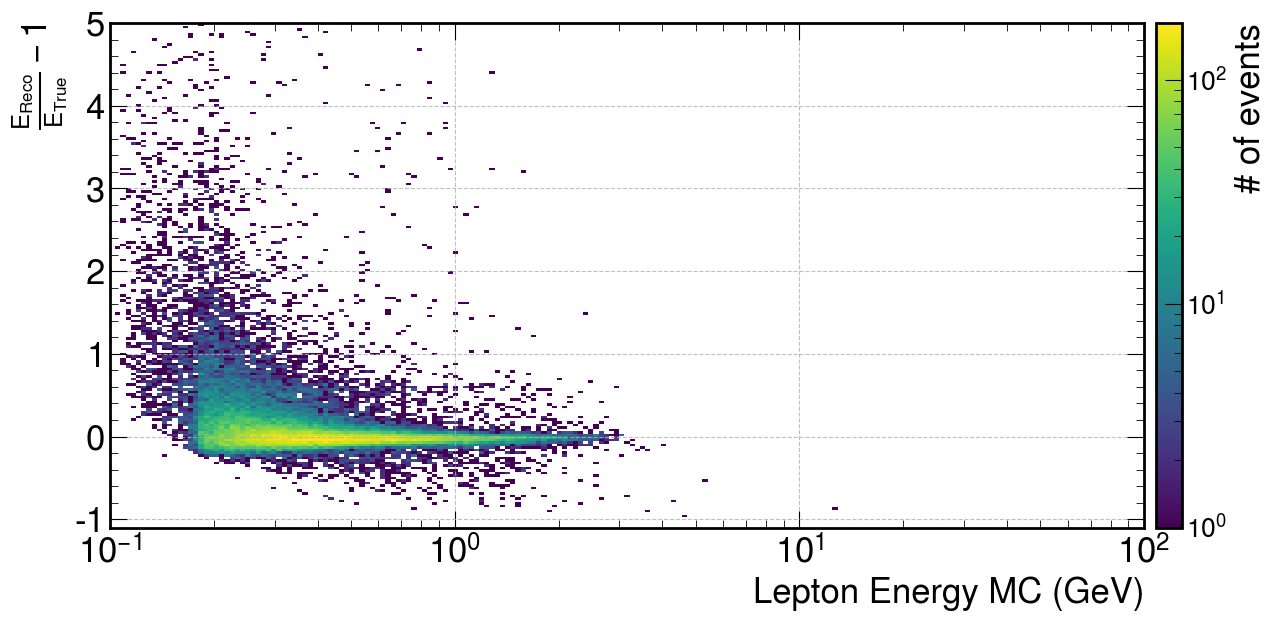

In [11]:
def event_check(df, onlycontained, Er):
    return df.filter(
            pl.col('contained')==onlycontained
        ).filter(
            pl.col(Er)>0
        ).filter(
            pl.col('trklen_pandoraTrack')>0
        # ).filter(
        #     pl.col('isinverted')==True
        # ).filter(
        #     check_fiducial('truth', safe_x=50, safe_y=50, safe_z=50)
        )

iscontained=True
Er = 'Ellhd'
df = dfmc.filter(pl.col('Ellhd')<99)
df = event_check(df, iscontained,Er)
display_2d(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')

df = dftrk
df = event_check(df, iscontained,Er)
display_2d(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')

df = dfsp
df = event_check(df, iscontained,Er)
display_2d(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')


# df = dfmc
# df = event_check(df, iscontained,Er)
# display_2d(df['E'], df[Er], makefrac=False, binsy=np.linspace(0,4,200), binsx=np.linspace(0,4,200), yscale='linear', xscale='linear', zscale=None)
# plt.plot([0,100],[0,100], ':', color='r')

# df = dftrk
# df = event_check(df, iscontained,Er)
# print(len(df))
# display_2d(df['E'], df[Er], makefrac=False, binsy=np.linspace(0,4,200), binsx=np.linspace(0,4,200), yscale='linear', xscale='linear', zscale=None)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dfout' is not defined

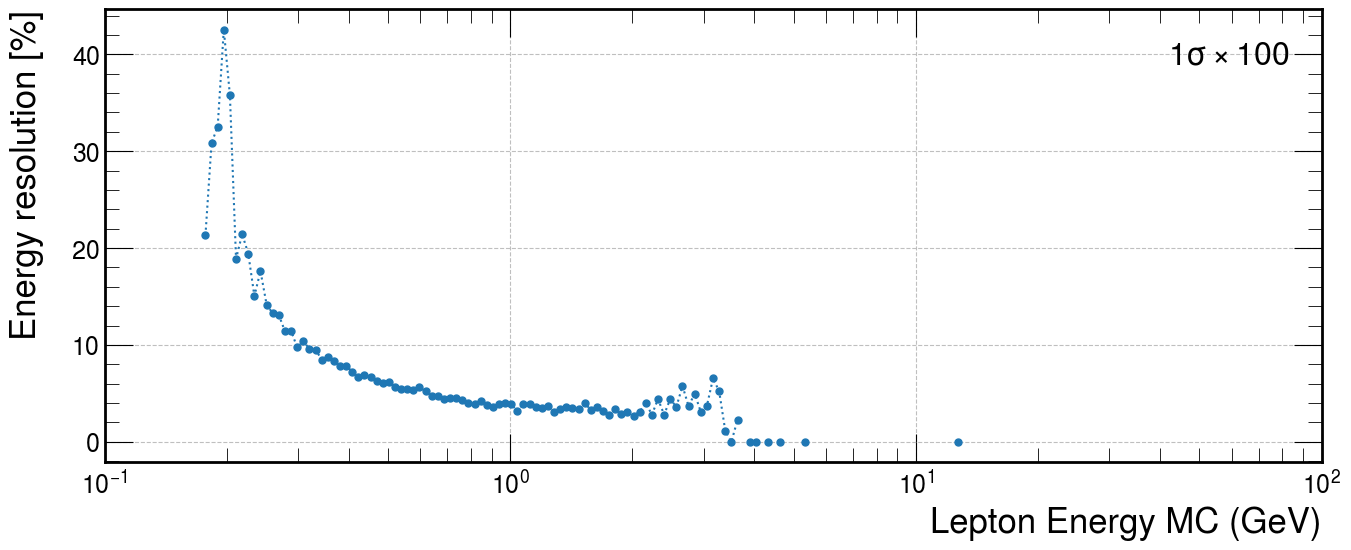

In [12]:

iscontained=True
plt.figure()
df = dfmc
df = event_check(df, iscontained,Er)
plot_res_scatter(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
df = dfout
df = event_check(df, iscontained,Er)
plot_res_scatter(df['E'], df[Er])#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
plt.ylim(0,200)


plt.figure()
df = dfmc
df = event_check(df, iscontained,Er)
plot_res_scatter(df['E'], df[Er], infotype='median')#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
df = dfout
df = event_check(df, iscontained,Er)
plot_res_scatter(df['E'], df[Er], infotype='median')#, makefrac=False, binsy=np.logspace(-1,2,200), yscale='log')
plt.ylim(-1,2)

In [371]:
len(df.filter(pl.col("contained")))

20037

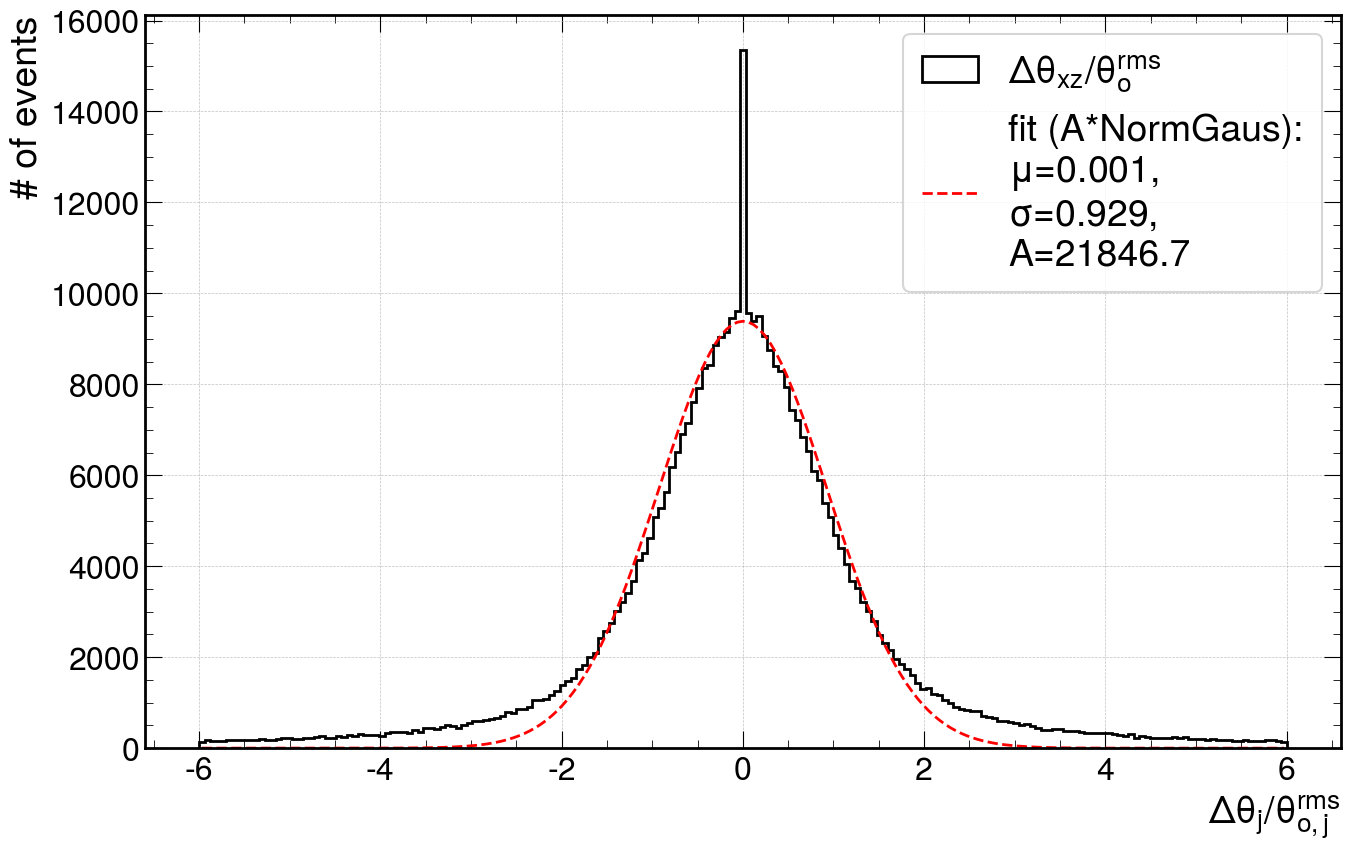

In [9]:
dfana_filter = dfana.select(selection_events())
mcsangle = mcsangle.join(dfana_filter, on=selection_events(), how='inner')
mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
    seg = (pl.col('ej')/0.0021)
    # theta = (1./(1.+pl.col('azx').tan()**2+pl.col('azy').tan()**2).sqrt()).arccos()#*pl.col('azx').sign()
    # theta = ((pl.col('azx')/1000).cos()*(pl.col('azy')/1000).cos()).arccos()*1000*(pl.col('azx')/1000).cos().sign()
)
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)
# dfplot = df.filter((pl.col('azx')).abs()>0.001)

plt.figure(figsize=(14,9))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigths, hedges, _ = plt.hist((dfplot['azx']/dfplot['rms']), bins=binsx, histtype='step', label=r'$\Delta\theta_{xz}/\theta^{rms}_o$',lw=2);
hcenters = (hedges[1:] + hedges[:-1])*0.5
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="fit (A*NormGaus):\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," "\n" "A=%5.1f" % tuple(popt), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
plt.legend(frameon=True, fontsize=27)

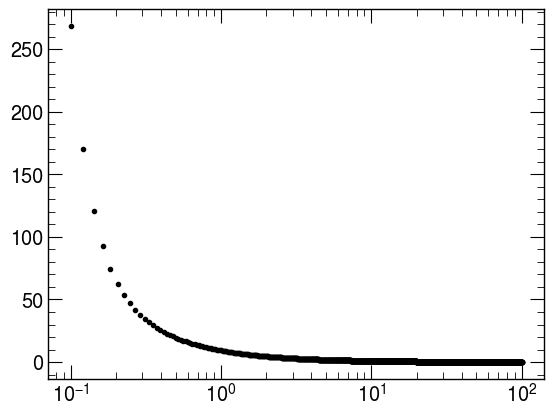

In [7]:
_p = np.arange(0.1, 100, 0.0021*10)
_ei = np.zeros_like(_p)
plt.plot(_p, compute_rms(_p, _ei),'.')
plt.xscale('log')
# plt.yscale('log')

In [295]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.count(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

describe,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64
"""count""",9202.0,9202.0,9202.0,9202.0,9202.0,9202.0,9202.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3782.358509,10.499457,39.540861,3.063356,417.810089,4.544684,0.107338
"""std""",2159.53186,5.752253,30.349687,5.552783,357.607594,7.772664,0.120795
"""min""",0.0,1.0,1.0,1.0,20.059796,0.108737,0.006711
"""25%""",1896.0,6.0,17.0,1.0,182.338121,0.94328,0.045455
"""50%""",3814.0,11.0,32.0,2.0,336.269528,2.010071,0.071429
"""75%""",5663.0,16.0,55.0,4.0,571.817244,4.629998,0.122449
"""max""",7499.0,20.0,286.0,170.0,13916.878502,92.595058,1.0


Text(0, 1, '# of events')

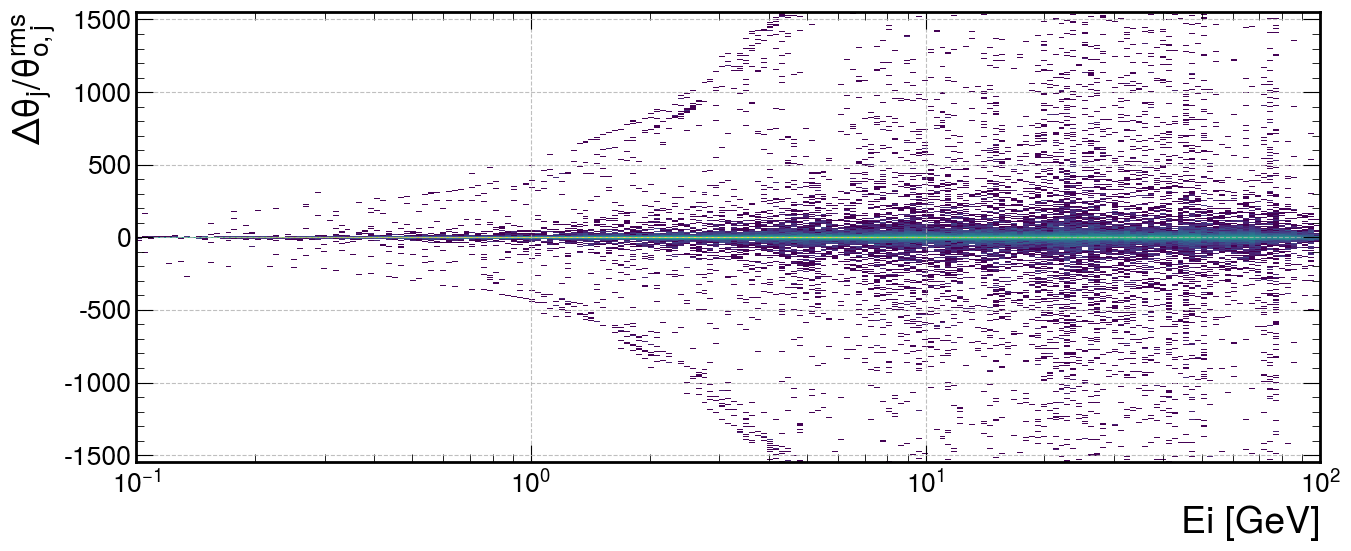

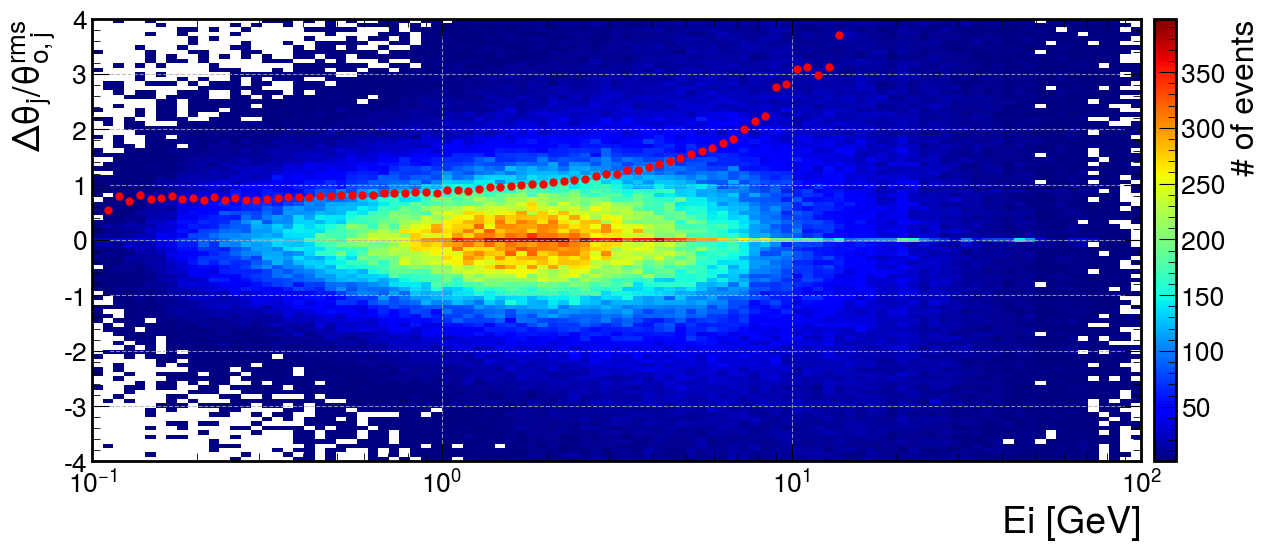

In [296]:

plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-1550,1550,500)], norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
binsx = np.logspace(-1,2,100)
val, _, _ = binned_statistic(dfplot['Ei'], dfplot['azx']/dfplot['rms'], manual_std, binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-4,4,100)], cmap=plt.cm.jet, cmin=1)
lines = plt.plot(bins_center, val, 'o', markersize=5, color='r',)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

In [297]:
# pl.Config.set_tbl_rows(40)
# dfout.group_by(selection_events()).agg(
#     pl.count(),# plot_res_vs_energy(dftemp['E'],
#                    dftemp['RecoLepEnNumu_range'],
#                    label=r'CSDA')
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

dfllhd = df.group_by(selection_events()).agg(
    pl.all().exclude('seg','len','p'),
    seg = pl.col('seg').first(),
    len = pl.col('len').first(),
    p = pl.col('p').first(),
)
vals = dfllhd.select(['theta', 'ei', 'ej', 'p', 'subrun', 'event', 'azx', 'azy','len']).to_numpy()
thetas = vals[:,0]
ei = vals[:,1]
ej = vals[:,2]
trueP = vals[:,3]
srun = vals[:,4]
evt = vals[:,5]
azx = vals[:,6]
azy = vals[:,7]
trklen = vals[:,8]


    

In [299]:
import numba as nb
ignoresmall = False
@nb.njit
def llhd(evDT, evEi, p, res, ignoresmall):
    a = 0.1049
    c = 11.0038


    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        dei = evEi[idx]
        nonrel_Eij = nonrel_Etot - dei
        # if nonrel_Eij < m_muon:
        #     return 99999

        nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
        # if nonrel_Eij*nonrel_Eij - m_muon*m_muon < 0:
        #     print(nonrel_Eij, m_muon, nonrel_Etot, p, dei, Ei)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
        tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)

        rms = (tH0**2 + res**2)
        if ignoresmall and dth < 0.07:
            continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms) - 0.5*dth*dth/rms
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Ei
    global ignoresmall 
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Ei[ev], p, res, ignoresmall)
    return result


idx: 20, subrun: 100, event: 18, p = 2.22


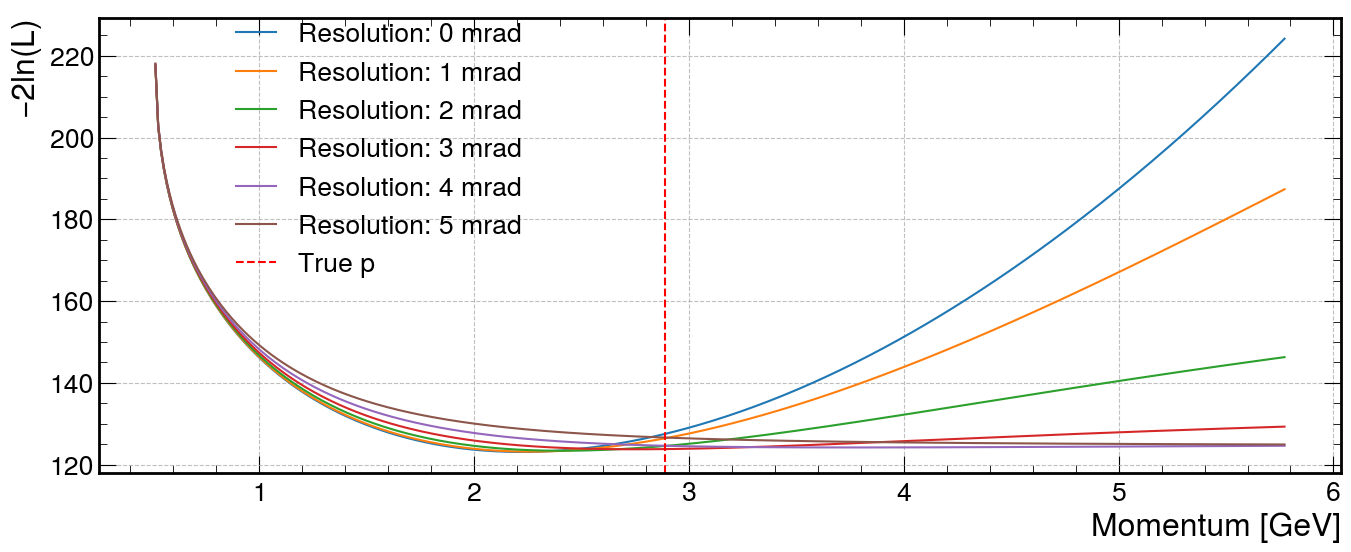

In [300]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=20
DT = thetas#[idx]/np.sqrt(2)
# DT = azy[idx]
global ei
Ei = ei#[idx]
for r,i in enumerate(res_scan):
    for x in np.linspace(np.sqrt(Ei[idx][-1]*(2*0.1057+Ei[idx][-1])) + 0.001, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, subrun: {srun[idx]}, event: {evt[idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}')

In [301]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=-1, deltatheta = None, resval = 0, fixres = True, limitres=(0,100)):
    global trueP
    global Ei
    global DT
    
    DT =deltatheta
    Ei = ei
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt != -1:
        p_ = trueP[start:maxevt]
        indexes = indexes[start:maxevt]
    else:
        p_ = trueP[start:]
        indexes = indexes[start:]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        minP = np.sqrt(Ei[ev][-1]*(2*0.1057+Ei[ev][-1])) + 0.001
        initalP = 1
        if initalP < minP: initalP=minP
        m = Minuit(call_llhd, p=initalP, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(minP,100)
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [302]:
trueE, recoE, fitS = lazy_min(0,-1, thetas/np.sqrt(2), 0, True)

100%|██████████| 15283/15283 [00:03<00:00, 4805.61it/s]


In [303]:
trueE_nosqrt, recoE_nosqrt, fitS_nosqrt = lazy_min(0,-1, thetas, 0, True)

100%|██████████| 15283/15283 [00:03<00:00, 4590.47it/s]


In [304]:
trueE_azx, recoE_azx, fitS_azx = lazy_min(0,-1, azx, 0, True)

100%|██████████| 15283/15283 [00:03<00:00, 4988.64it/s]


In [305]:
trueE_azy, recoE_azy, fitS_azy = lazy_min(0,-1, azy, 0, True)
# trueE_fitres, recoE_fitres, fitS_fitres = lazy_min(0,-1, thetas, False)

100%|██████████| 15283/15283 [00:03<00:00, 4878.99it/s]


In [306]:
# trueE_at2, recoE_at2, fitS_at2 = lazy_min(0,-1, thetas/np.sqrt(2), fixres=True, resval=2)
# trueE_azx_at2, recoE_azx_at2, fitS_azx_at2 = lazy_min(0,-1, azx, fixres=True, resval=2)
# trueE_azx_at2_sqrt, recoE_azx_at2_sqrt, fitS_azx_at2_sqrt = lazy_min(0,-1, azx*np.sqrt(2), fixres=True, resval=2)
# trueE_azx_sqrt, recoE_azx_sqrt, fitS_azx_sqrt = lazy_min(0,-1, azx*np.sqrt(2), fixres=True, resval=0)

In [307]:
trueE_nosqrt_extra, recoE_nosqrt_extra, fitS_nosqrt_extra = lazy_min(0,-1, thetas*1.1, 0,True)

100%|██████████| 15283/15283 [00:03<00:00, 5020.51it/s]


In [308]:
ignoresmall = True
trueE_nosqrt_skip, recoE_nosqrt_skip, fitS_nosqrt_skip = lazy_min(0,-1, thetas, 0, True)
ignoresmall = False

100%|██████████| 15283/15283 [00:03<00:00, 4850.47it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

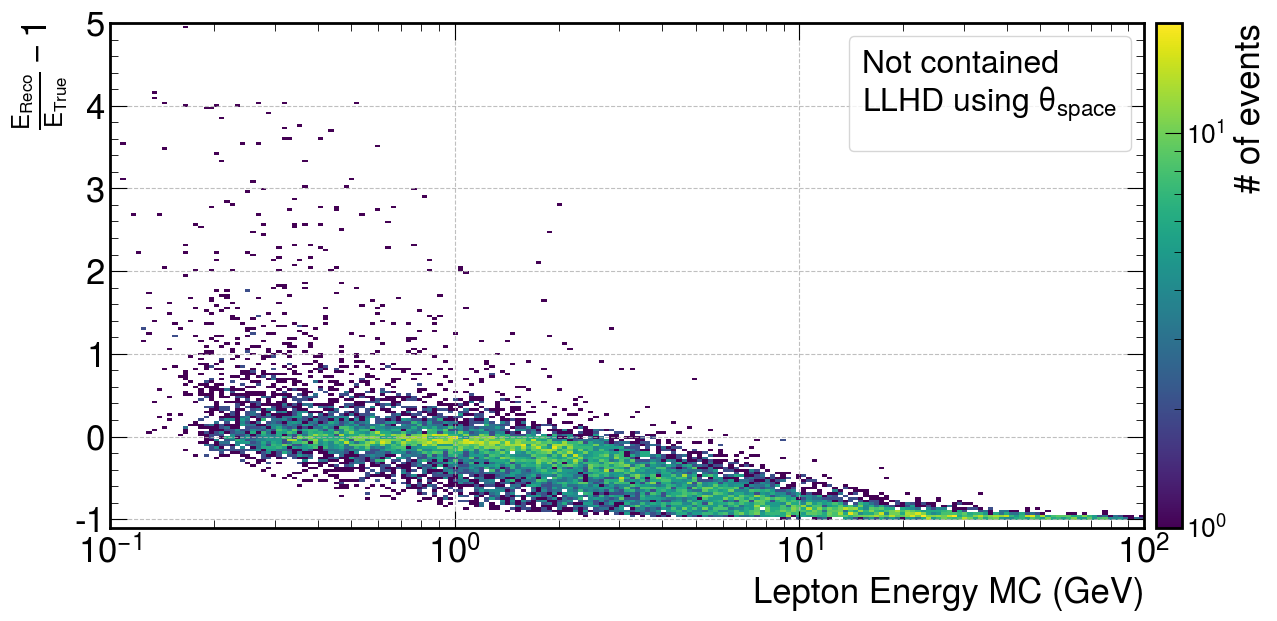

<Figure size 1400x600 with 0 Axes>

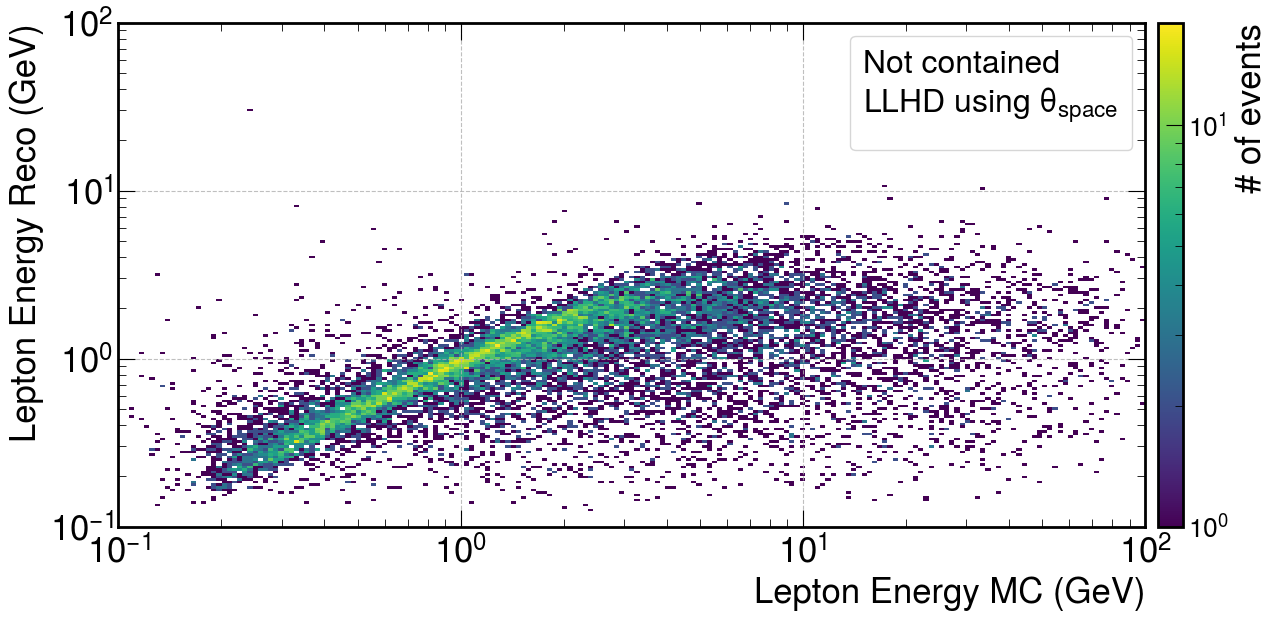

In [309]:
def display_en_reco(x,
                    y,
                    actualx = None,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    figsize=(14,6.7)):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.plot();
display_en_reco(trueE_nosqrt,
                recoE_nosqrt,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE_nosqrt_skip,
                recoE_nosqrt_skip,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )

(0.0, 200.0)

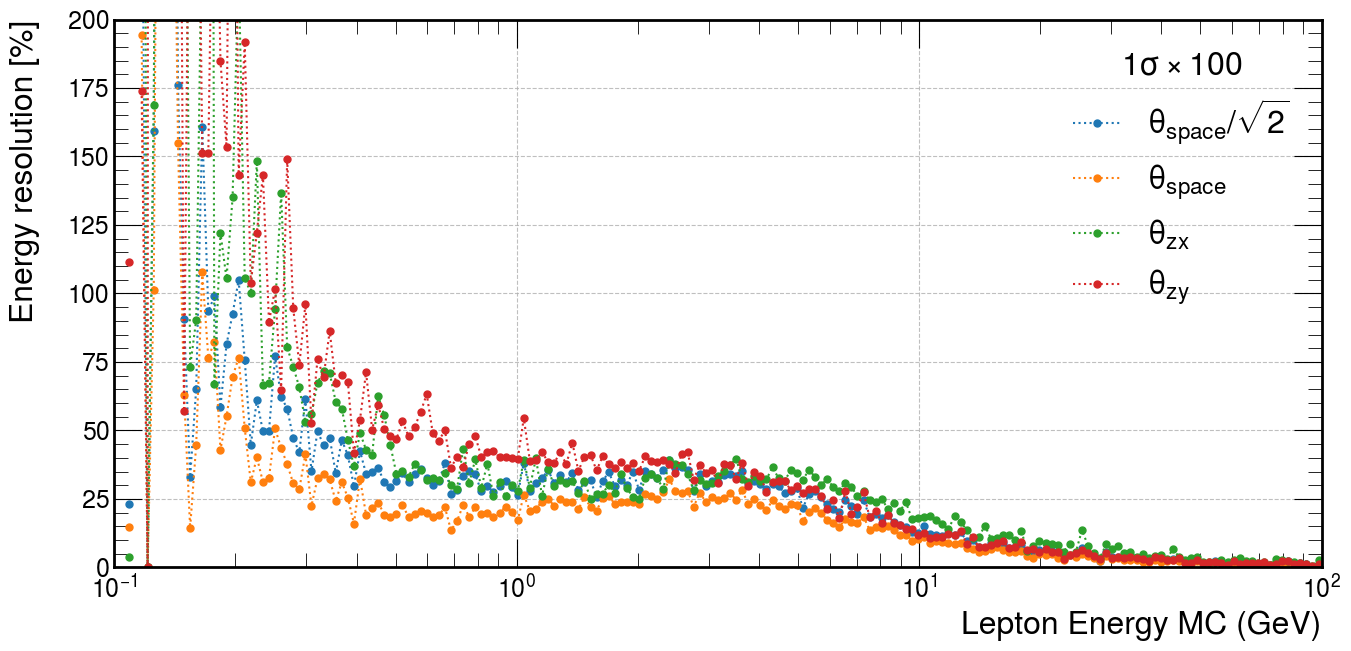

In [311]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,200), fmt = '.:', infotype='std', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    lines = ax.plot(bins_center, val, fmt, markersize=10, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23, labelpad=labelpad)
    ax.set_xscale('log')
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                  recoE,
                  label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueE_nosqrt,
                  recoE_nosqrt,
                  label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_azx,
                  recoE_azx,
                  label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azy,
                  recoE_azy,
                  label=r'$\theta_{zy}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-1.0, 2.0)

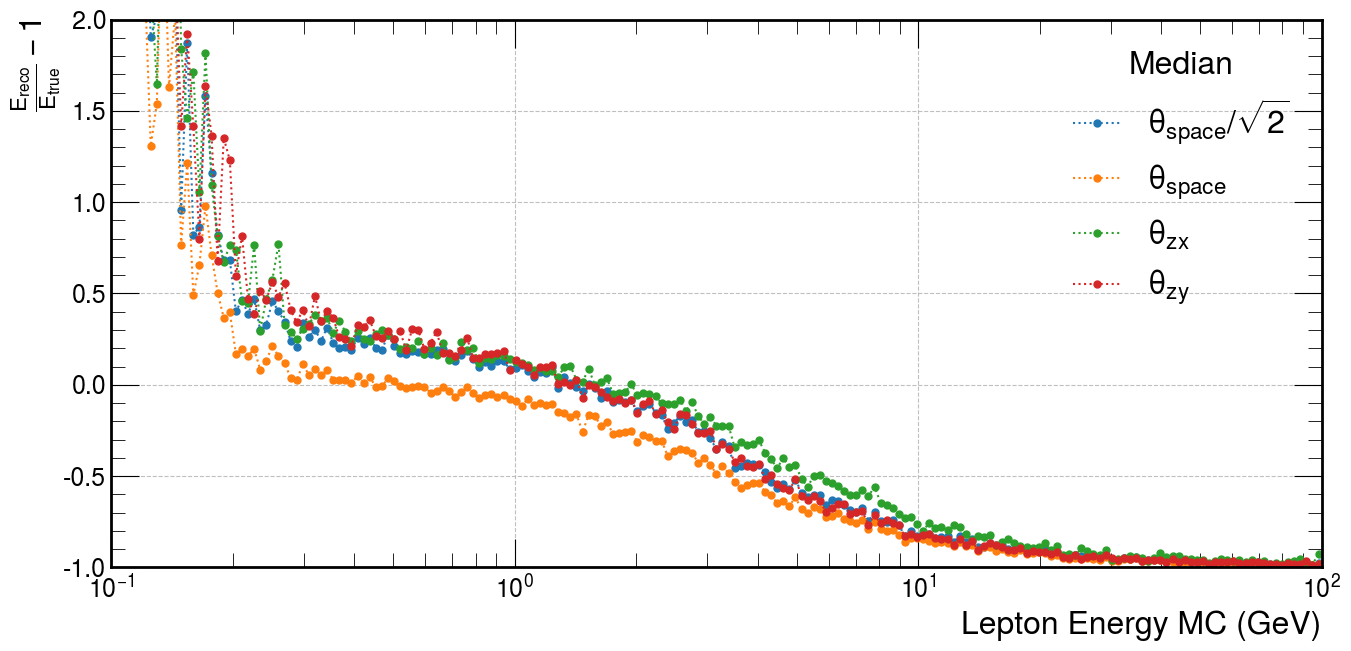

In [312]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   infotype='median',
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   infotype='median',
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azy,
                   recoE_azy,
                   infotype='median',
                   label=r'$\theta_{zy}$')
# plot_median_vs_energy(trueE_zeroR, recoE_zeroR,  markersize=10, label=r'$\theta_{space}$, res = 2 mrad')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,2)
# plt.yscale('log')

NameError: name 'trueE_azx_at2' is not defined

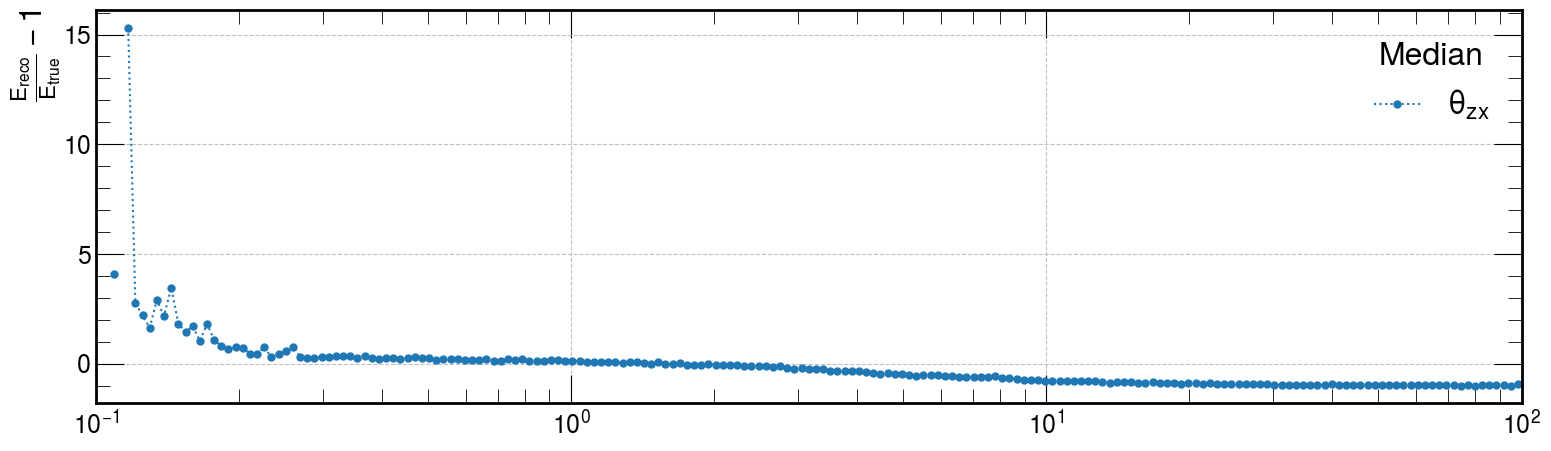

In [350]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   infotype='median',
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azx_at2,
                   recoE_azx_at2,
                   infotype='median',
                   label=r'$\theta_{zx}$ (res = 2 mrad)')
plot_res_vs_energy(trueE_azx_sqrt,
                   recoE_azx_sqrt,
                   infotype='median',
                   label=r'$\theta_{zx}\times\sqrt{2}$')
plot_res_vs_energy(trueE_azx_at2_sqrt,
                   recoE_azx_at2_sqrt,
                   infotype='median',
                   label=r'$\theta_{zx}\times\sqrt{2}$ (res = 2 mrad)')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(-1,2)

plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azx_at2,
                   recoE_azx_at2,
                   label=r'$\theta_{zx}$ (res = 2 mrad)')
plot_res_vs_energy(trueE_azx_sqrt,
                   recoE_azx_sqrt,
                   label=r'$\theta_{zx}\times\sqrt{2}$')
plot_res_vs_energy(trueE_azx_at2_sqrt,
                   recoE_azx_at2_sqrt,
                   label=r'$\theta_{zx}\times\sqrt{2}$ (res = 2 mrad)')
# plot_median_vs_energy(trueE_zeroR, recoE_zeroR,  markersize=10, label=r'$\theta_{space}$, res = 2 mrad')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)


Reading nu files... 15/15

Reading reco_tracks files... 15/15




(0.0, 200.0)

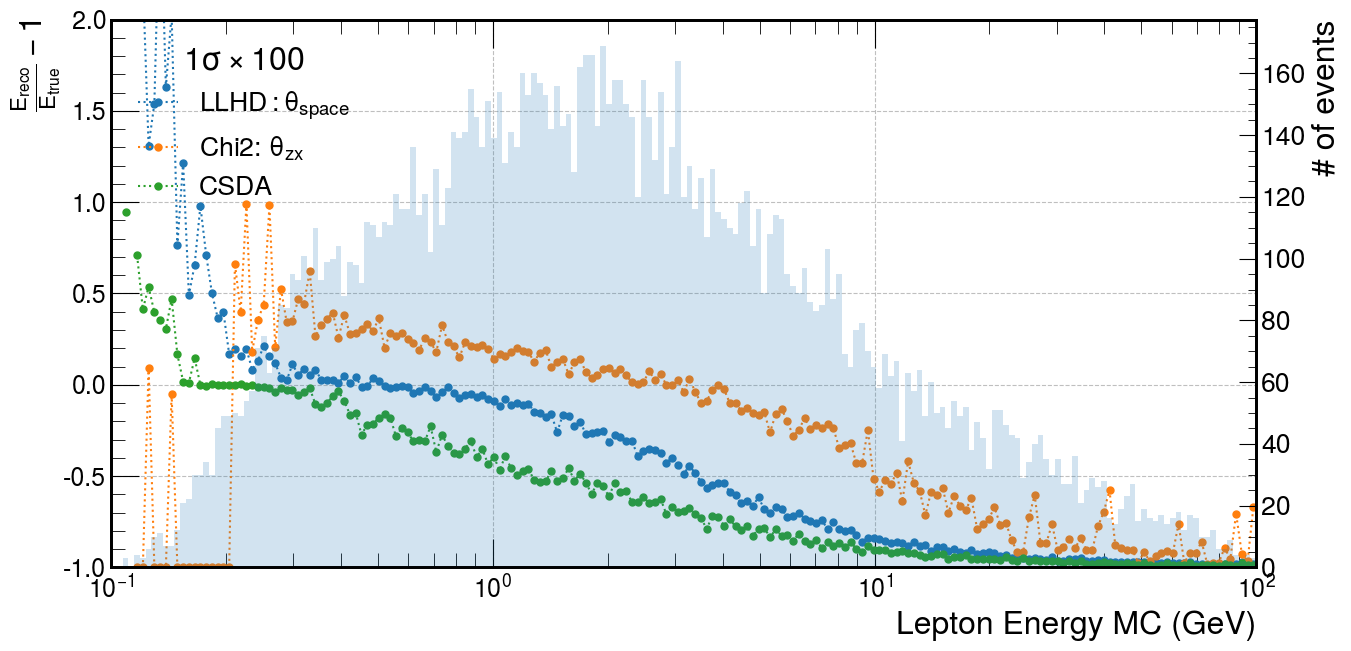

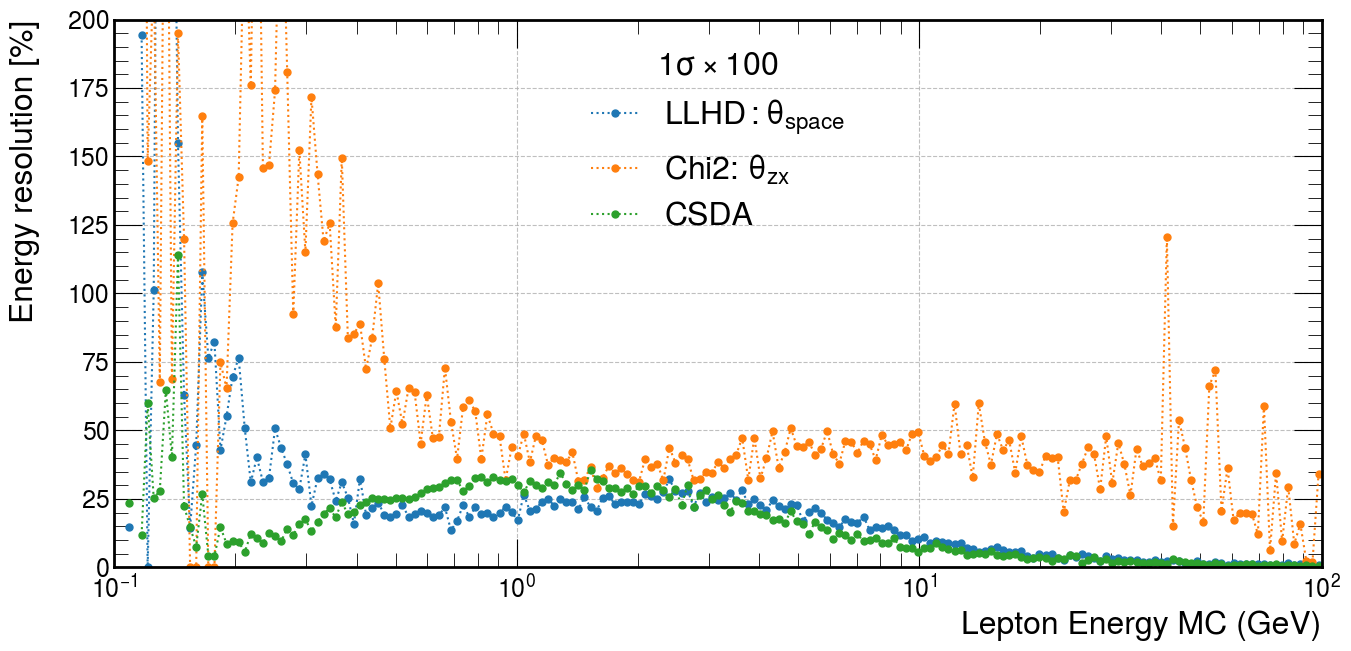

In [351]:
anatree_temp = Anatree(f'{data_path}/parquet_original_trklen_lower', load_data=False)
anatree_temp.read_parquet(f'{data_path}/parquet_original_trklen_lower')

dftemp = select_numu_cc(anatree_temp.nu.collect())
dftrack = anatree_temp.reco_tracks.collect().select(selection_events('trklen_pandoraTrack'))
dftrack = dftrack.group_by(selection_events()).agg(
    trklen = pl.col('trklen_pandoraTrack').sort().last()
)
dftemp = dftemp.join(dftrack, on=selection_events(), how='inner')
dftemp = dftemp.with_columns(
    Ereco = pl.col('RecoLepEnNumu_mcs_chi2')
)

plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                #    actualx=recoE_nosqrt,
                   infotype='median',
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                #    actualx=dftemp['Ereco'],
                   infotype='median',
                   label=r'Chi2: $\theta_{zx}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['RecoLepEnNumu_range'],
                #    actualx=dftemp['RecoLepEnNumu_range'],
                   infotype='median',
                   label=r'CSDA')
ax = plt.gca()
ax.set_xlabel('Lepton Energy MC (GeV)', fontsize=23)
ax.set_ylim(-1,2)

ax2 = ax.twinx()
ax2.hist(dftemp['E'], bins=np.logspace(-1,2,200), alpha=0.2)
ax2.set_ylabel(rf'# of events')
ax2.grid(False)
ax.legend(loc='upper left', title='MPV')
ax.legend(loc='upper left', title=r'1$\sigma\times100$')
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                #    actualx=recoE_nosqrt,
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                #    actualx=dftemp['Ereco'],
                   label=r'Chi2: $\theta_{zx}$')
plot_res_vs_energy(dftemp['E'],
                   dftemp['RecoLepEnNumu_range'],
                #    actualx=dftemp['RecoLepEnNumu_range'],
                   label=r'CSDA')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)

In [ ]:
dftemp.with_columns(Er=pl.col("Ereco")/pl.col("E")-1).select(['subrun','event','Ereco','trklen', "Er", "LongestTrackContNumu"]).describe()

describe,subrun,event,Ereco,trklen,Er,LongestTrackContNumu
str,f64,f64,f64,f64,f64,f64
"""count""",15434.0,15434.0,15434.0,15434.0,15434.0,15434.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3810.79448,10.541013,4.36644,404.032013,0.960008,0.0
"""std""",2133.86193,5.722953,12.516185,1273.691772,12.007143,0.0
"""min""",0.0,1.0,0.0,10.029287,-1.0,0.0
"""25%""",1951.0,6.0,0.751355,99.965012,-0.413432,0.0
"""50%""",3818.0,11.0,1.67476,240.506882,0.015726,0.0
"""75%""",5666.0,15.0,3.518025,478.645081,0.335699,0.0
"""max""",7499.0,20.0,101.536026,85121.25,504.625305,0.0


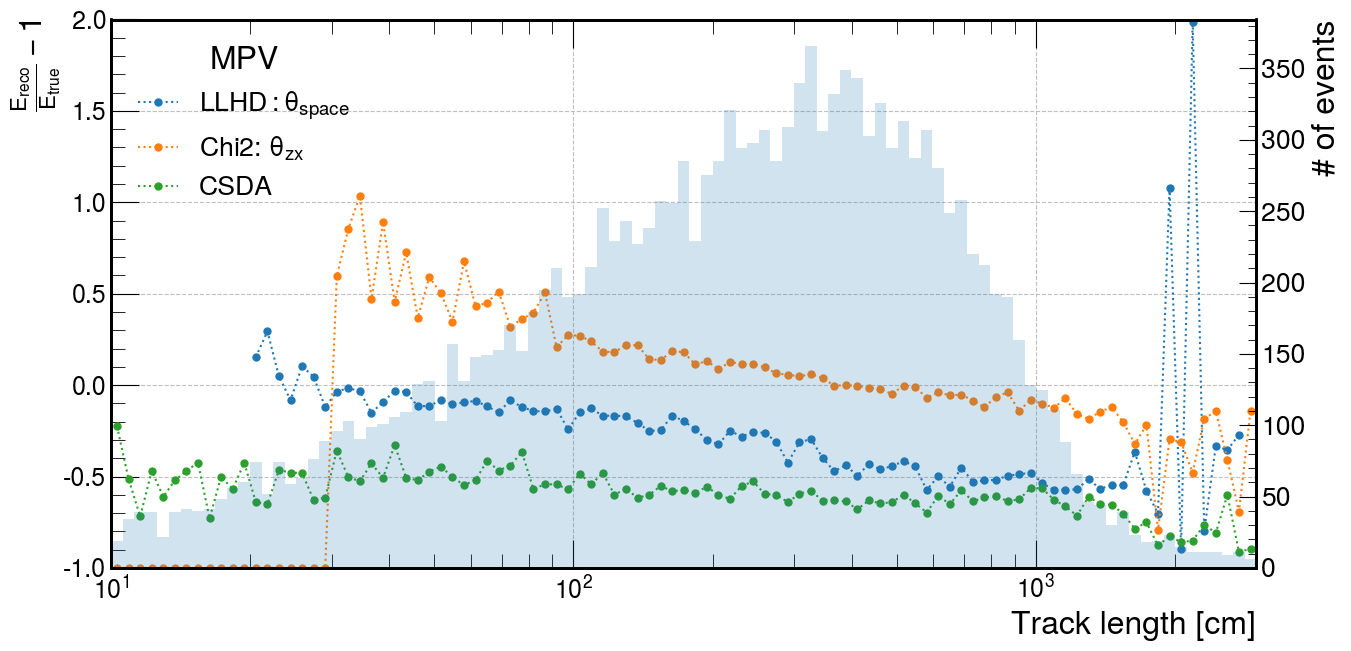

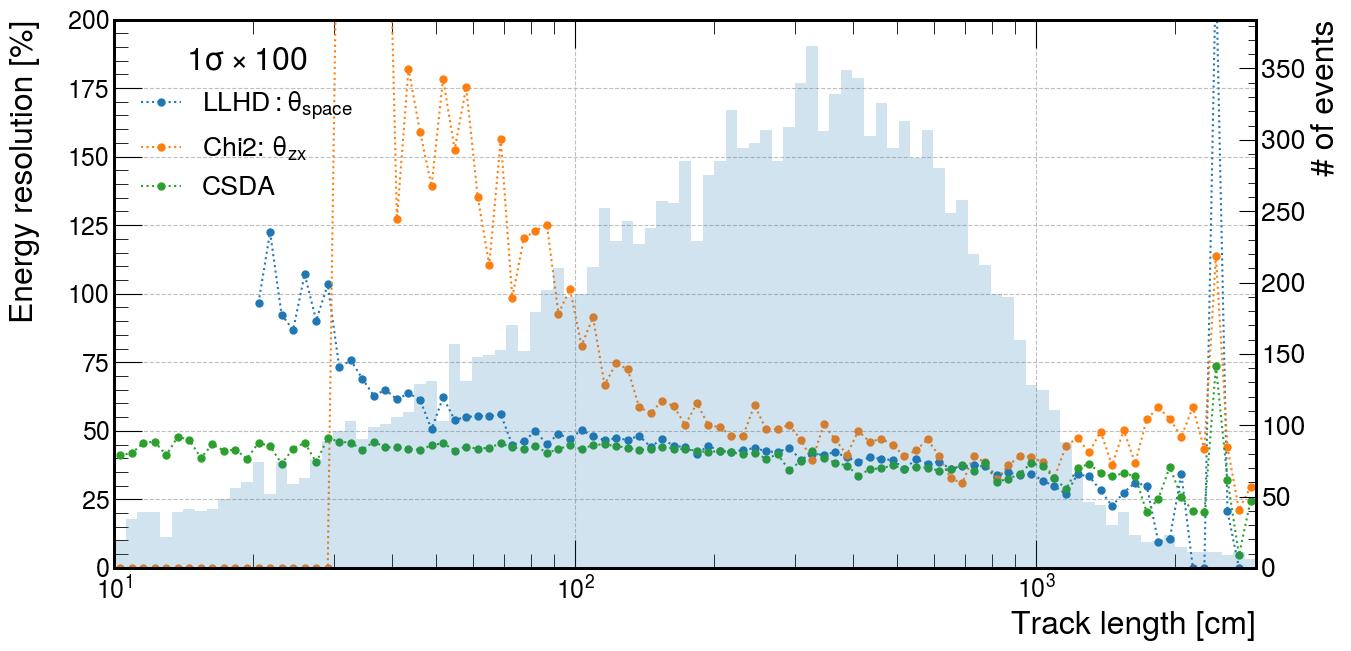

In [320]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   actualx=trklen,
                   binsx=np.logspace(1,np.log10(3000),100),
                   infotype='median',
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   actualx=dftemp['trklen'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   infotype='median',
                   label=r'Chi2: $\theta_{zx}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['RecoLepEnNumu_range'],
                   actualx=dftemp['trklen'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   infotype='median',
                   label=r'CSDA')

ax = plt.gca()
ax2 = ax.twinx()
ax2.hist(dftemp['trklen'], bins=np.logspace(1,np.log10(3000),100), alpha=0.2)
ax2.set_ylabel(rf'# of events')
ax2.grid(False)
ax.set_xlabel('Track length [cm]', fontsize=23)
ax.set_ylim(-1,2)
ax.legend(loc='upper left', title='MPV')

plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   actualx=trklen,
                   binsx=np.logspace(1,np.log10(3000),100),
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   actualx=dftemp['trklen'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   label=r'Chi2: $\theta_{zx}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['RecoLepEnNumu_range'],
                   actualx=dftemp['trklen'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   label=r'CSDA')
ax = plt.gca()
ax.set_xlabel('Track length [cm]', fontsize=23)
ax.set_ylim(0,200)

ax2 = ax.twinx()
ax2.hist(dftemp['trklen'], bins=np.logspace(1,np.log10(3000),100), alpha=0.2)
ax2.set_ylabel(rf'# of events')
ax2.grid(False)
ax.legend(loc='upper left', title='MPV')
ax.legend(loc='upper left', title=r'1$\sigma\times100$')

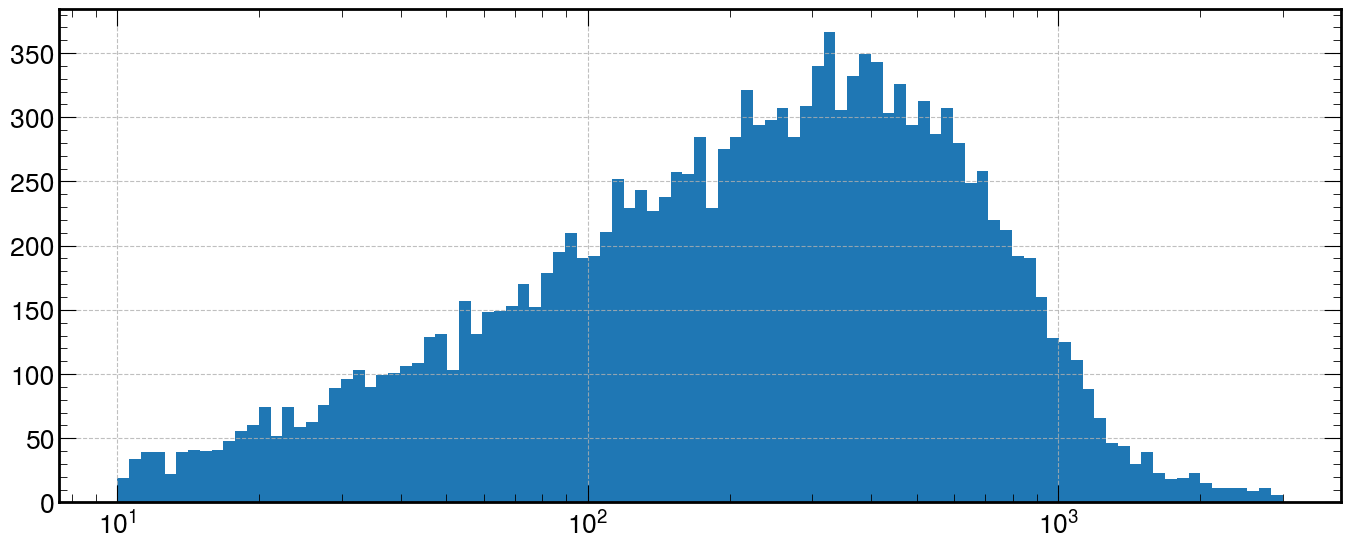

In [ ]:
plt.hist(dftemp['trklen'], bins=np.logspace(1,np.log10(3000),100));
plt.xscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x700 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

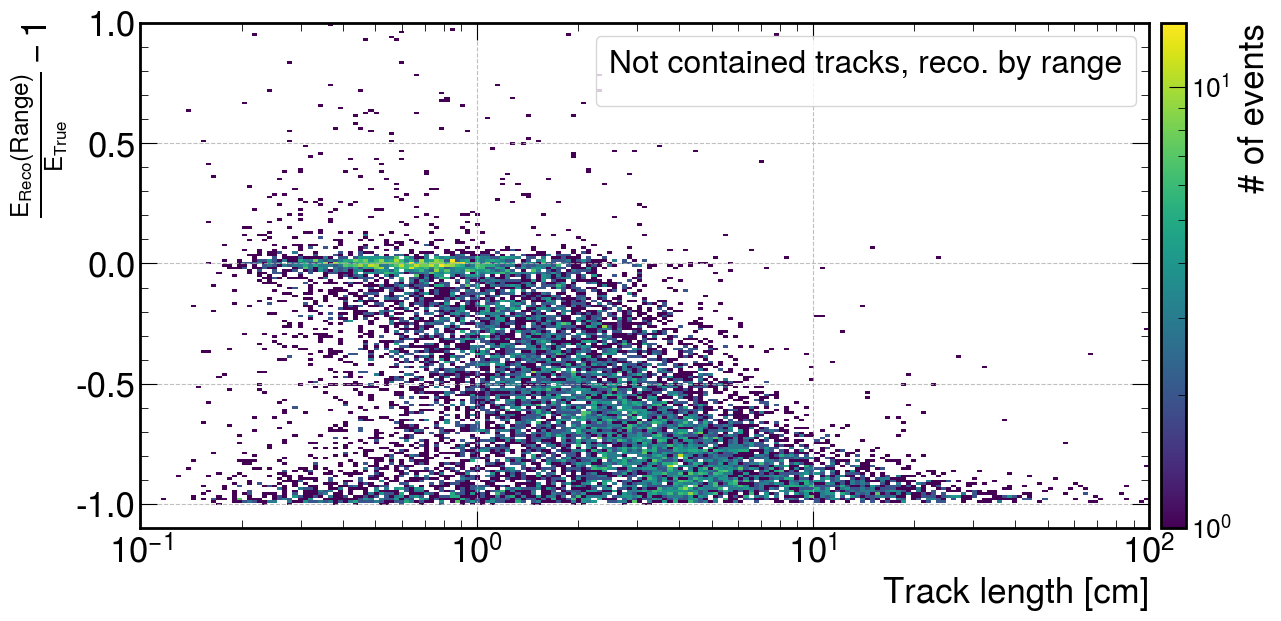

<Figure size 1400x600 with 0 Axes>

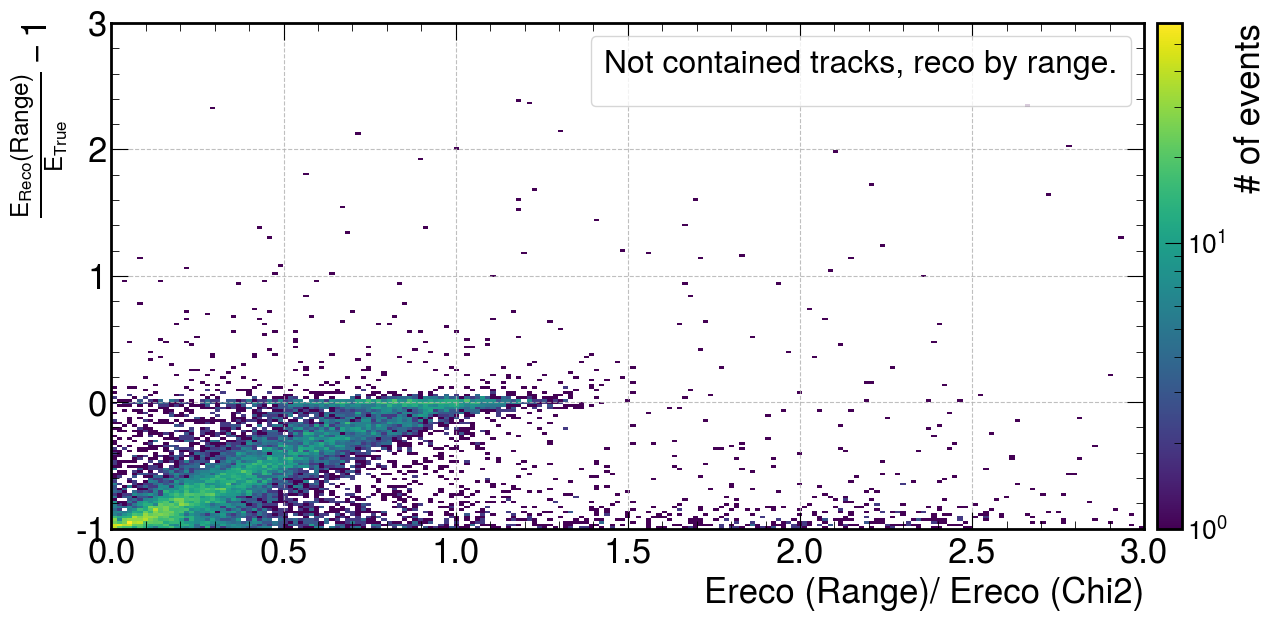

<Figure size 1400x600 with 0 Axes>

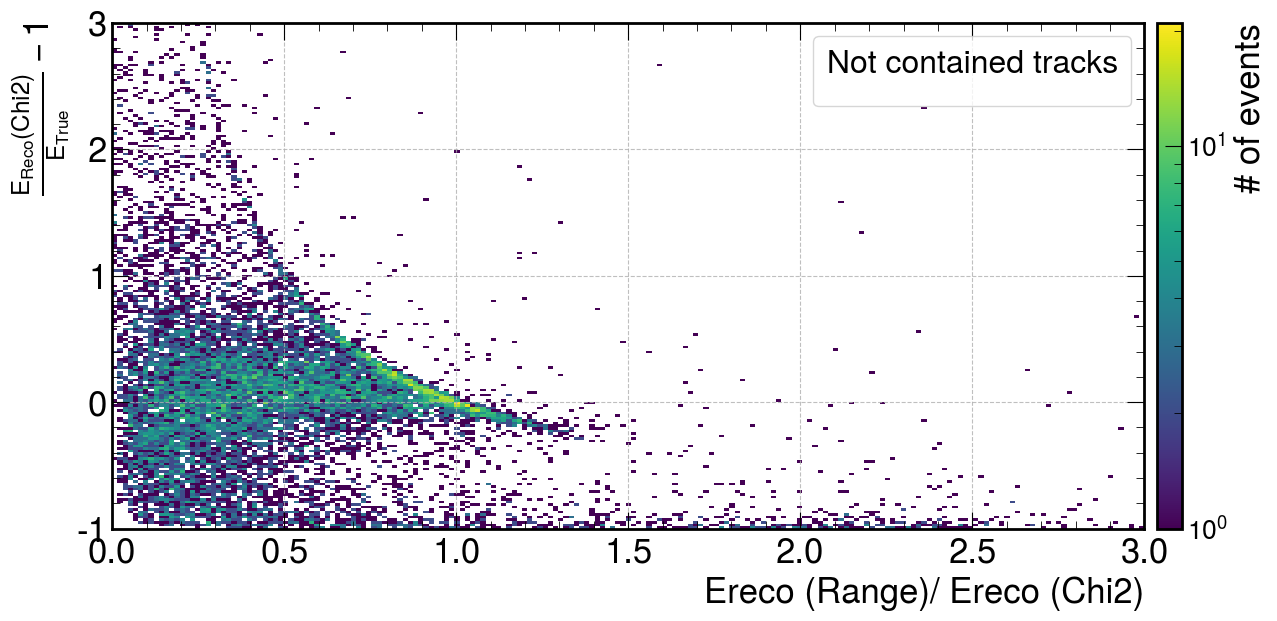

In [322]:
# dfthreshold = anatree_temp.nu.collect()
# dfthreshold = select_numu_cc(dfthreshold, True, 0)
# dfthre= dfthreshold.join(anatree_temp.reco_tracks.collect(), on=selection_events())
dfthre = dftemp

plt.figure(figsize=[12,7])
display_en_reco(
    dfthre['E'],
    y = dfthre['RecoLepEnNumu_range'],
    actualx=dfthre['Ereco'],
    # binse = np.logspace(1,np.log10(3000),100),
    binsy = np.linspace(-1.1,1,200),
    lmethod = "Not contained tracks, reco. by range" ,
    ylabel=r'$\frac{E_{Reco} (Range)}{E_{True}} - 1$'
)
plt.xlabel('Track length [cm]')

display_en_reco(
    x = dfthre['RecoLepEnNumu_range']/dfthre['RecoLepEnNumu_mcs_chi2'],
    y = dfthre['RecoLepEnNumu_range']/dfthre['E']-1,
    binsy = np.linspace(-1,3,200),
    binse = np.linspace(0,3,200),
    lmethod = "Not contained tracks, reco by range.",
    makefrac=False,
    xscale='linear',
    xlabel=r'Ereco (Range)/ Ereco (Chi2)',
    ylabel=r'$\frac{E_{Reco} (Range)}{E_{True}} - 1$'
    # ylabel=r'Ereco (Range)/ Ereco (Chi2)',
)
display_en_reco(
    x = dfthre['RecoLepEnNumu_range']/dfthre['RecoLepEnNumu_mcs_chi2'],
    y = dfthre['RecoLepEnNumu_mcs_chi2']/dfthre['E']-1,
    binsy = np.linspace(-1,3,200),
    binse = np.linspace(0,3,200),
    lmethod = "Not contained tracks",
    makefrac=False,
    xscale='linear',
    xlabel=r'Ereco (Range)/ Ereco (Chi2)',
    ylabel=r'$\frac{E_{Reco} (Chi2)}{E_{True}} - 1$'
)

(0.0, 200.0)

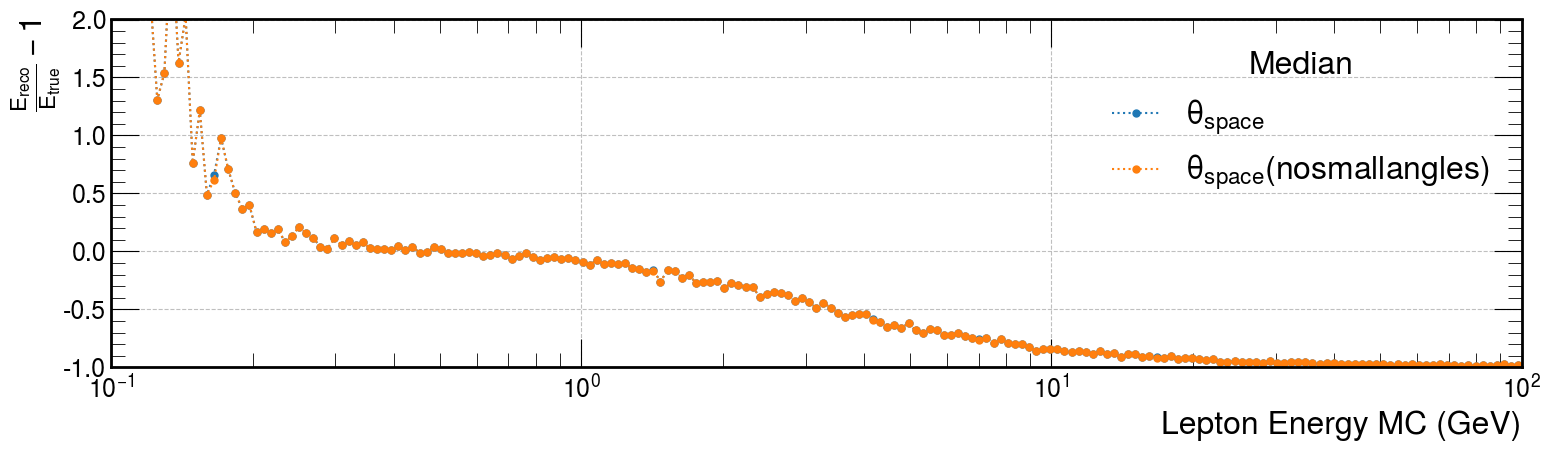

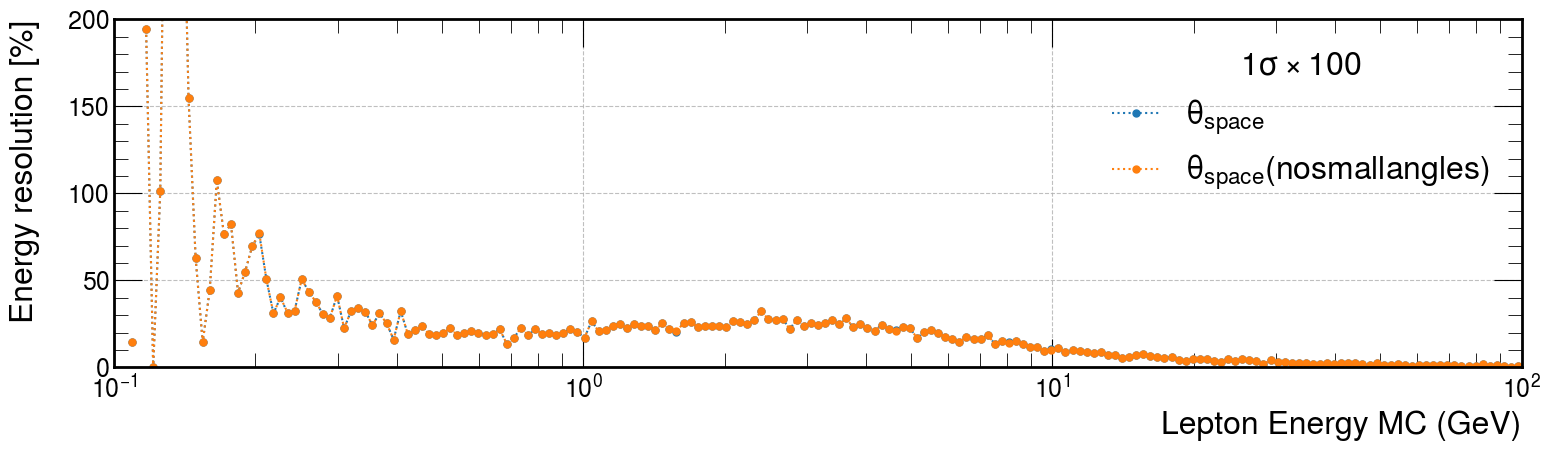

In [284]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   infotype='median',
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_nosqrt_skip,
                   recoE_nosqrt_skip,
                   infotype='median',
                   label=r'$\theta_{space} (no small angles)$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(-1,2)

plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_nosqrt_skip,
                   recoE_nosqrt_skip,
                   label=r'$\theta_{space} (no small angles)$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)
